In [6]:
import boost_histogram as bh
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import histogram_builder as hb
import mplhep as hep
from scipy.optimize import curve_fit
# plt.style.use(hep.style.ROOT)
plt.style.use("fivethirtyeight")


# =========================
# LOAD RUN METADATA
# =========================

runs_df = pd.read_csv("/Users/juliogutierrez/Downloads/R-sidis_analysis/LD2.csv")
runs_df["weight_factor"] = 1 / (runs_df["charge"] * runs_df["hEff"] * runs_df["hDead"])

Al_thick = 0.36  # mm
dummy_thick = 0.60605  # mm
R = Al_thick / dummy_thick
normfac = 0.100031E+12

# HMS Delta

Average relative difference: 9.77%


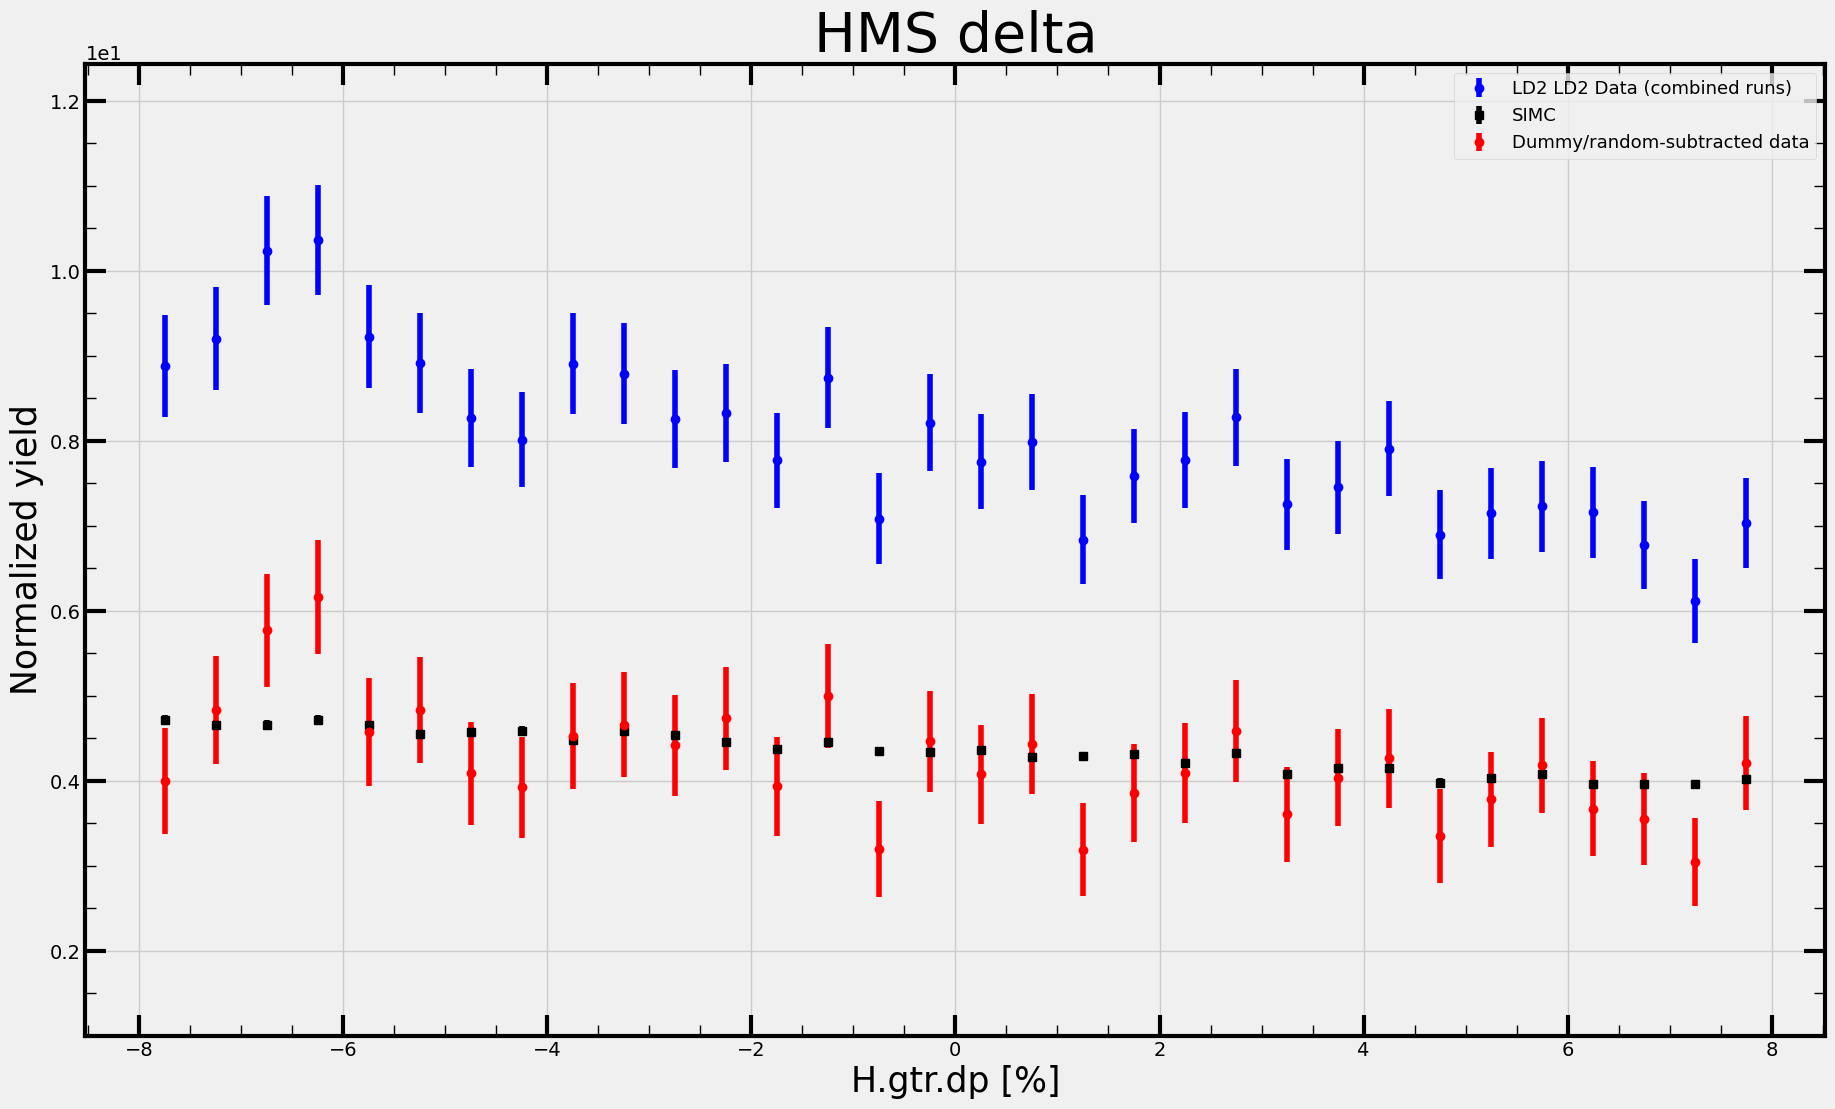

In [3]:
plt.style.use("fivethirtyeight")

bin_num = 32
var_to_plot = ["H.gtr.dp","hsdelta"]
bin_range = (-8, 8)
Al_thick = 0.184  # mm
dummy_thick = 0.60605  # mm
R = Al_thick / dummy_thick
normfac = 0.838913E+11 

histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(20, 12))

# plt.step(histo["centers_data"], histo["counts_data"], where='mid', label='Data', color='blue')
# plt.step(histo["centers_sim"], histo["counts_sim"], where='mid', label='SIMC', color='black')
# plt.fill_between(histo["centers_sub"], 0, histo["counts_sub"], step='mid', alpha=0.3, color='red', label='Dummy-subtracted')
plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='LD2 LD2 Data (combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='red', label="Dummy/random-subtracted data")
plt.xlabel("H.gtr.dp [%]", fontsize=25)
plt.ylabel("Normalized yield", fontsize=25)
plt.ylim(1, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.minorticks_on()
ax=plt.gca()
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')
plt.tick_params(which='major', length=15, width=3, direction='in', bottom=True, top=True, left=True, right=True)
plt.tick_params(which='minor', length=8, width=1, direction='in', bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.titlesize"] = 40  
plt.title("HMS delta")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()



# SHMS Delta

Average relative difference: 17.92%


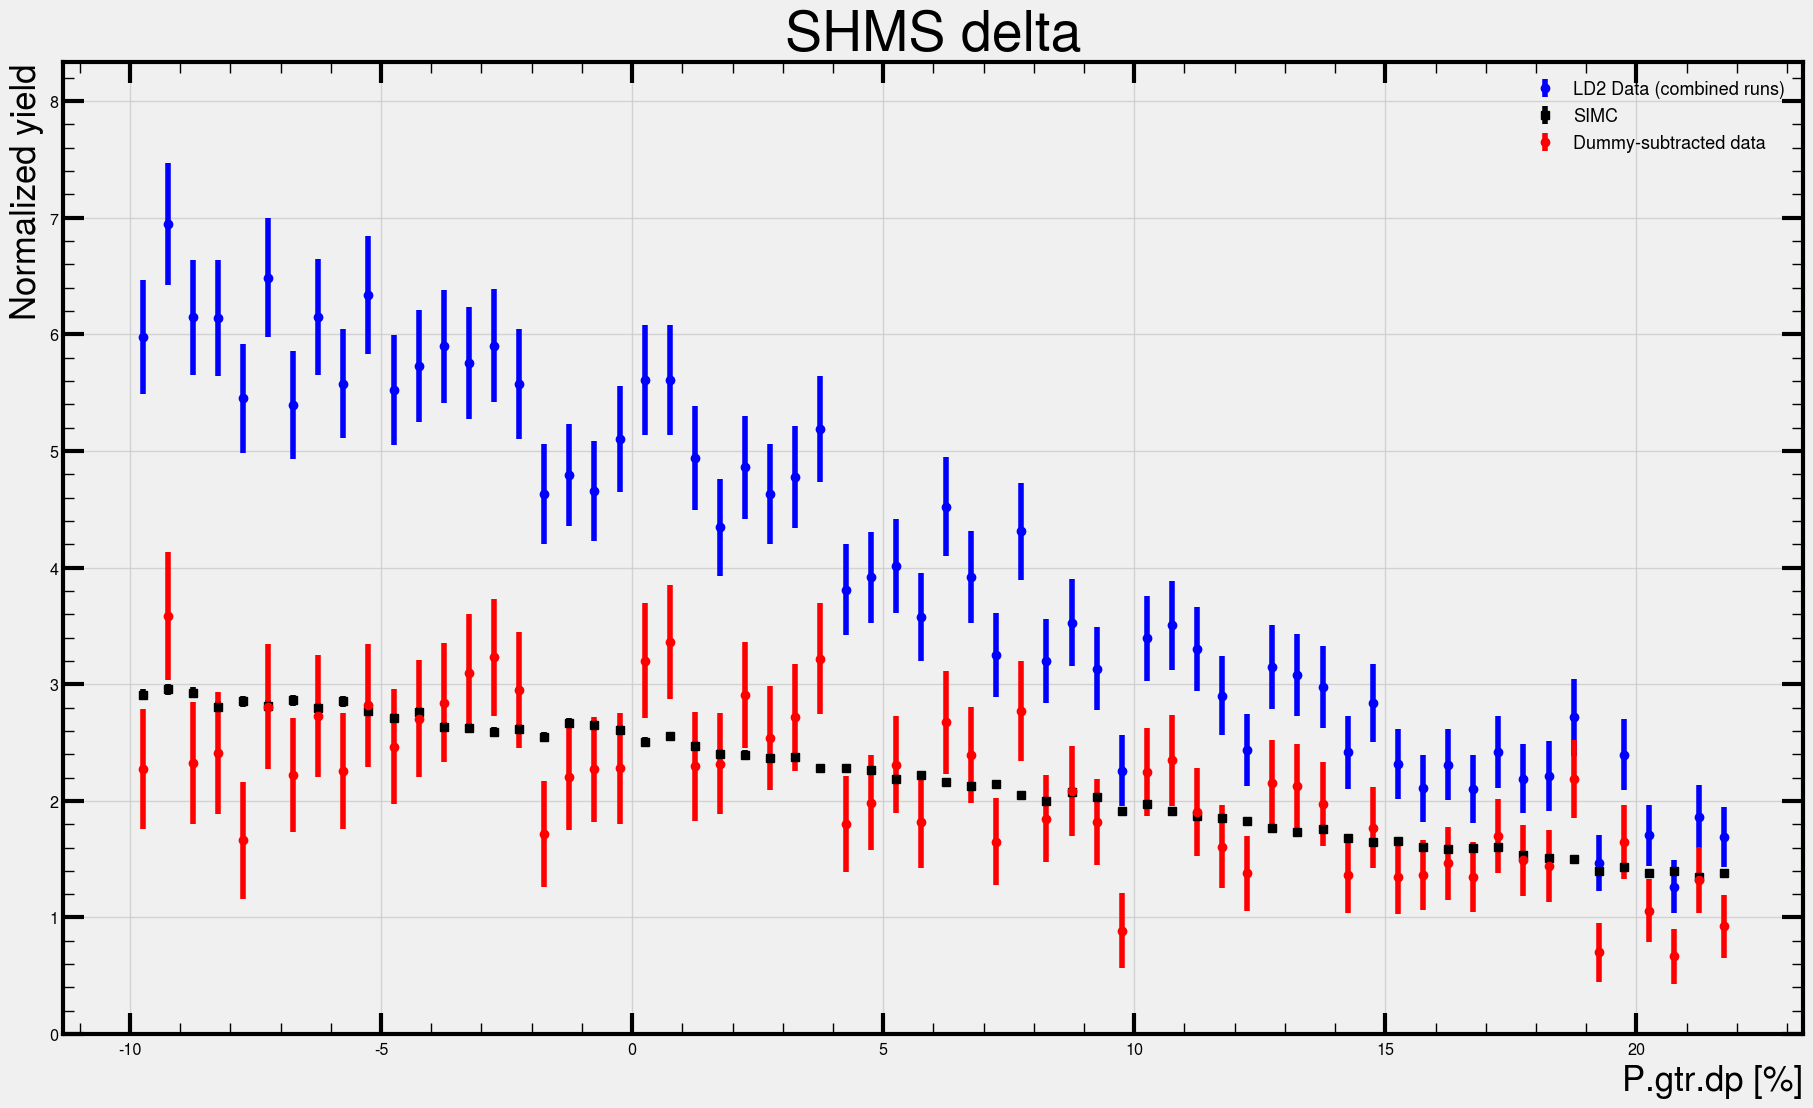

In [11]:
plt.style.use("fivethirtyeight")

bin_num = 64
var_to_plot = ["P.gtr.dp","ssdelta"]
bin_range = (-10, 22)

histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(20, 12))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='LD2 Data (combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='red', label="Dummy-subtracted data")
plt.xlabel("P.gtr.dp [%]", fontsize=25)
plt.ylabel("Normalized yield", fontsize=25)
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.minorticks_on()
ax=plt.gca()
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')
plt.tick_params(which='major', length=15, width=3, direction='in', bottom=True, top=True, left=True, right=True)
plt.tick_params(which='minor', length=8, width=1, direction='in', bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.titlesize"] = 40  
plt.title("SHMS delta")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

# HMS ytar

Average relative difference: 29.57%


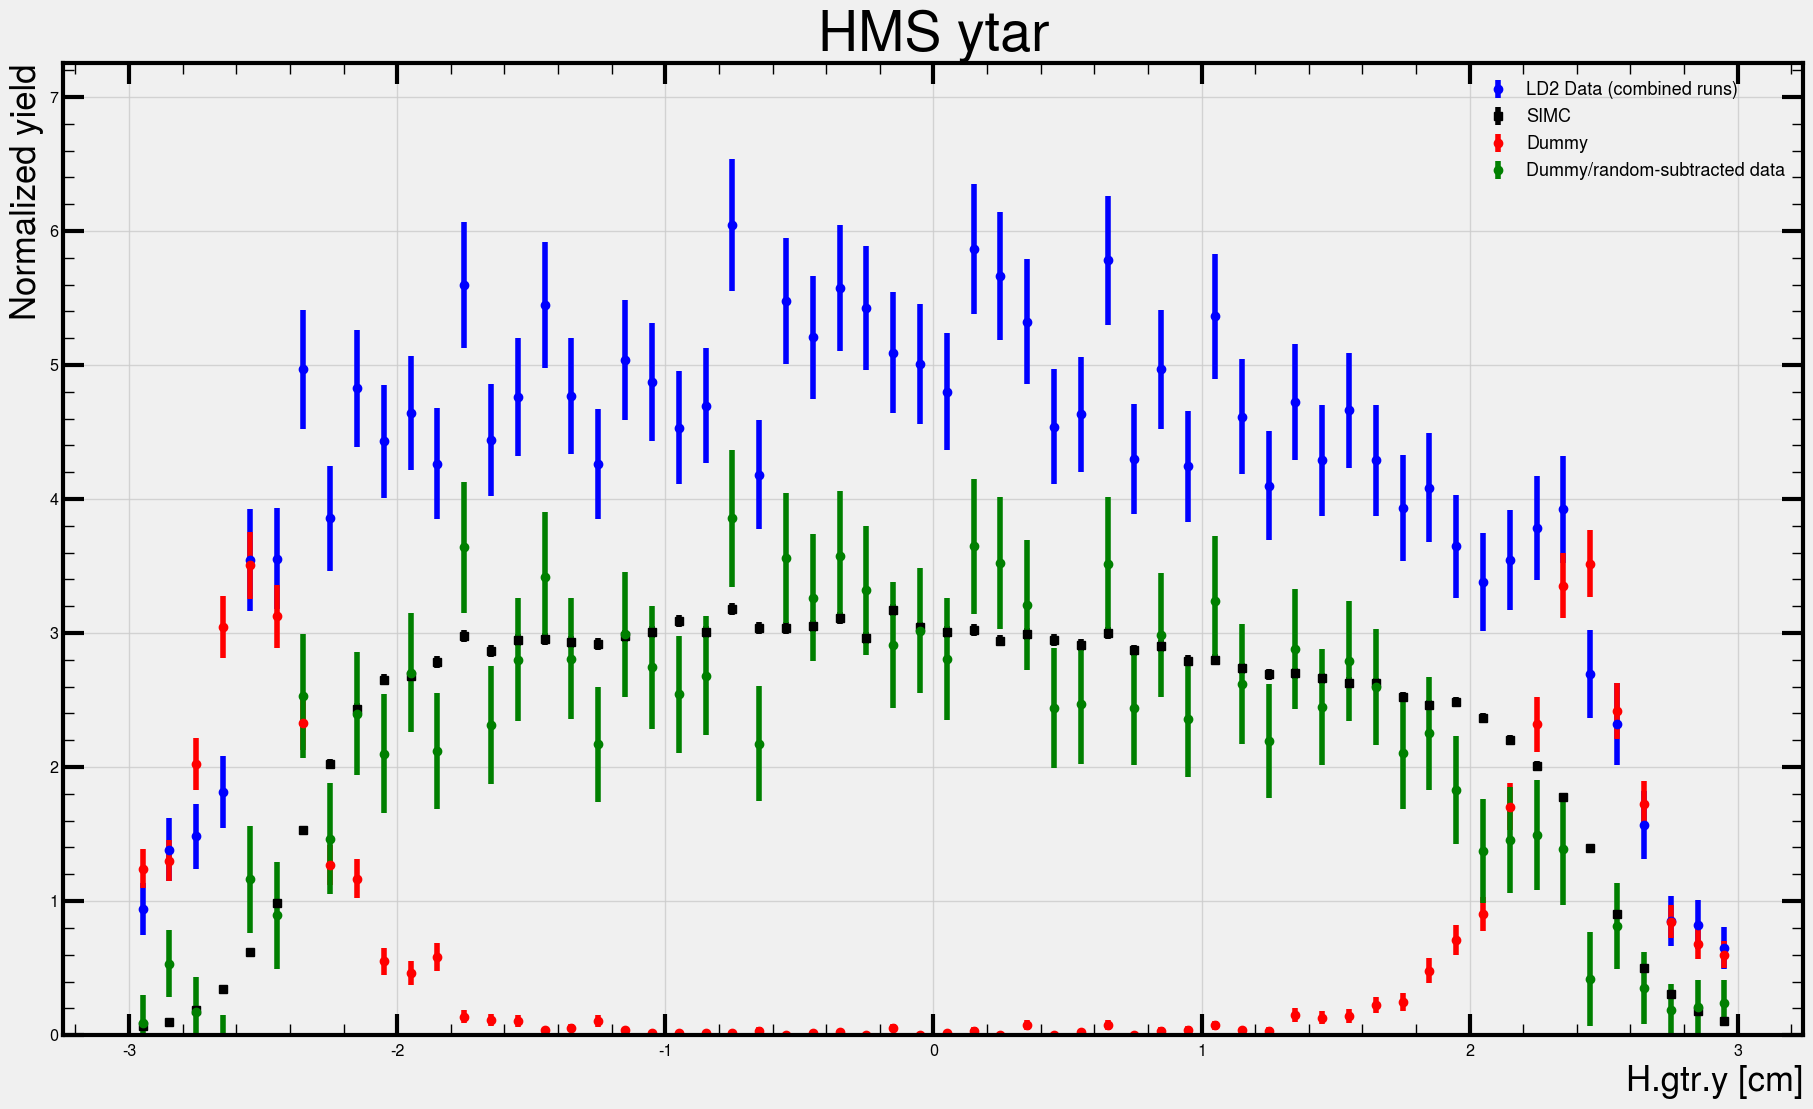

In [12]:
bin_num = 60
var_to_plot = ["H.gtr.y","hsytar"]
bin_range = (-3, 3)

histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(20, 12))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='LD2 Data (combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy/random-subtracted data")
plt.xlabel("H.gtr.y [cm]", fontsize=25)
plt.ylabel("Normalized yield", fontsize=25)
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.minorticks_on()
ax=plt.gca()
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')
plt.tick_params(which='major', length=15, width=3, direction='in', bottom=True, top=True, left=True, right=True)
plt.tick_params(which='minor', length=8, width=1, direction='in', bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.titlesize"] = 40  
plt.title("HMS ytar")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

# SHMS ytar

Average relative difference: 117.82%


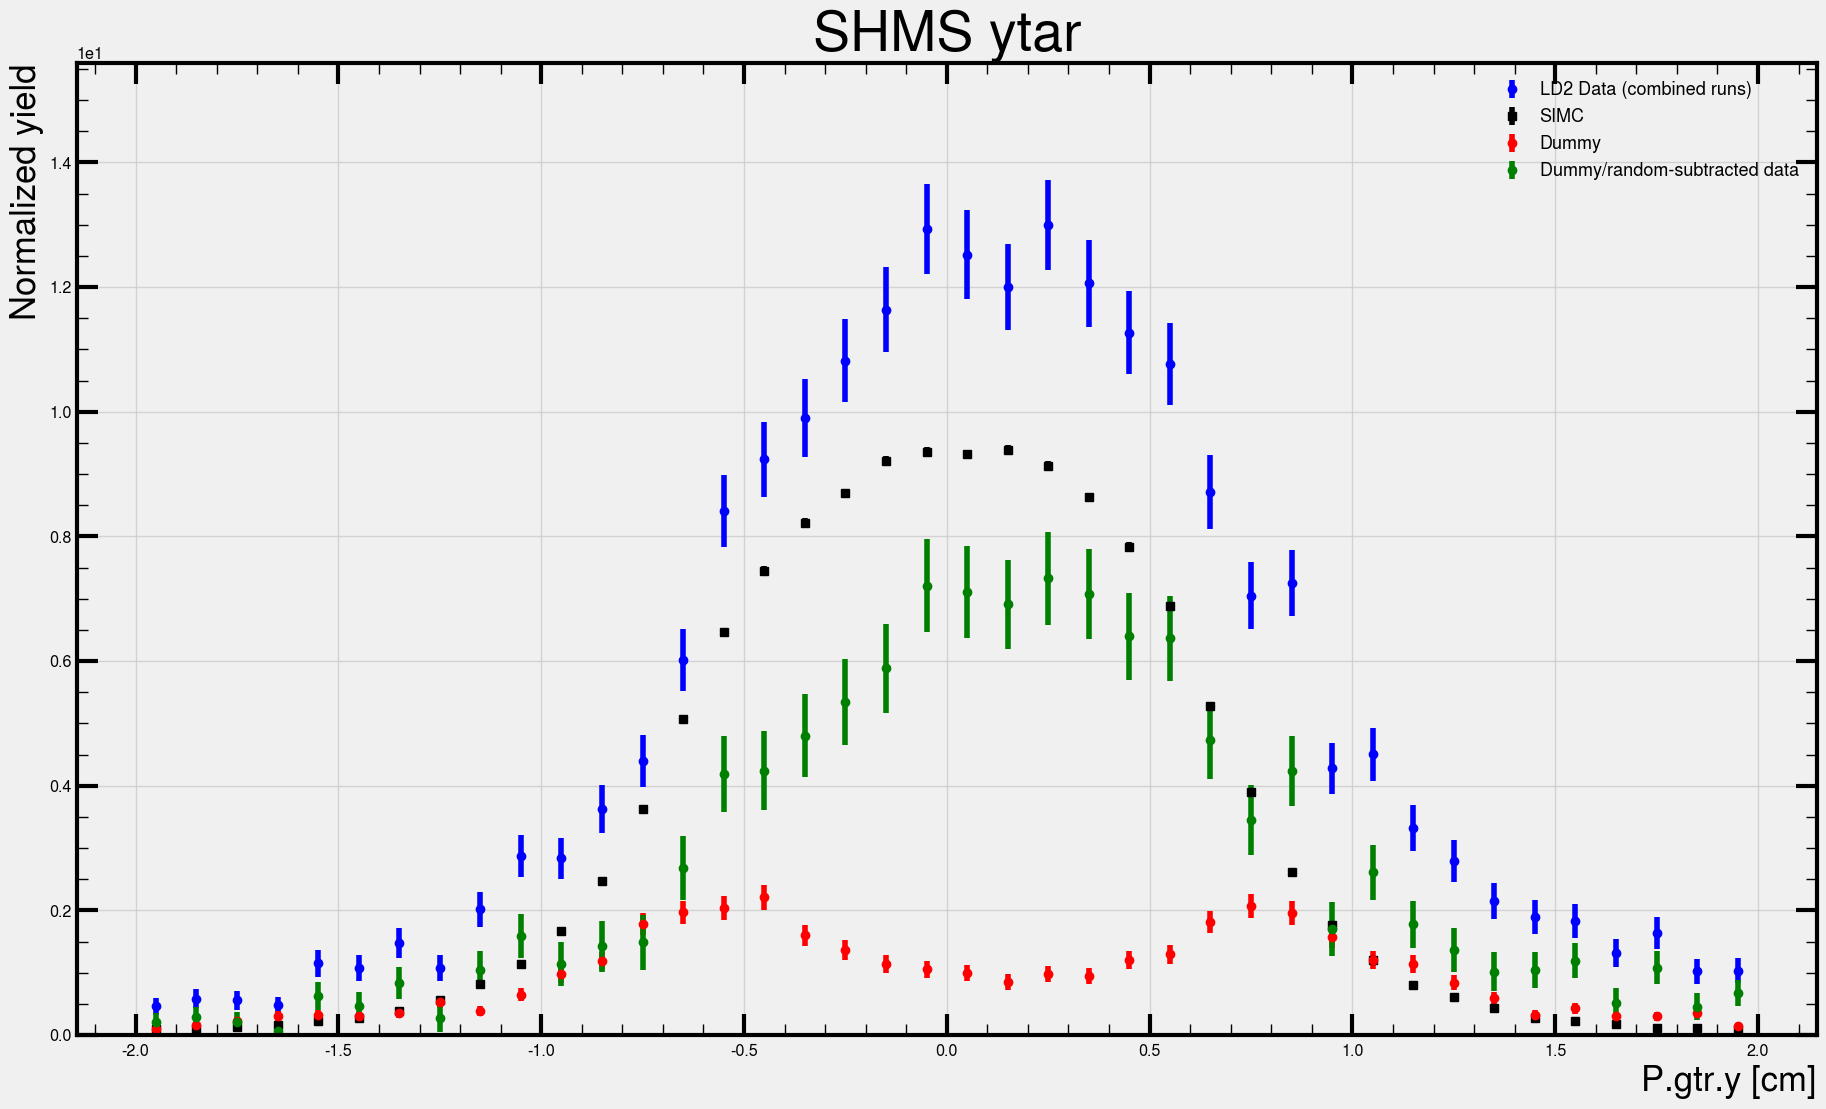

In [13]:
bin_num = 40
var_to_plot = ["P.gtr.y","ssytar"]
bin_range = (-2, 2)

histo = make_histograms(bin_num, bin_range)

diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")

plt.figure(figsize=(20, 12))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='LD2 Data (combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy/random-subtracted data")
plt.xlabel("P.gtr.y [cm]", fontsize=25)
plt.ylabel("Normalized yield", fontsize=25)
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.minorticks_on()
ax=plt.gca()
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')
plt.tick_params(which='major', length=15, width=3, direction='in', bottom=True, top=True, left=True, right=True)
plt.tick_params(which='minor', length=8, width=1, direction='in', bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.titlesize"] = 40  
plt.title("SHMS ytar")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

# Bjorken-x

/var/folders/z9/0b_f0vqx7yz487m29qrdk82w0000gn/T/ipykernel_993/737144475.py:25: RuntimeWarning: divide by zero encountered in divide
  diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]
/var/folders/z9/0b_f0vqx7yz487m29qrdk82w0000gn/T/ipykernel_993/737144475.py:25: RuntimeWarning: invalid value encountered in divide
  diff_percent = 100 * (histo["counts_sub"] - histo["counts_sim"]) / histo["counts_sim"]


Average relative difference: nan%
μ = 0.2490 ± 0.0005


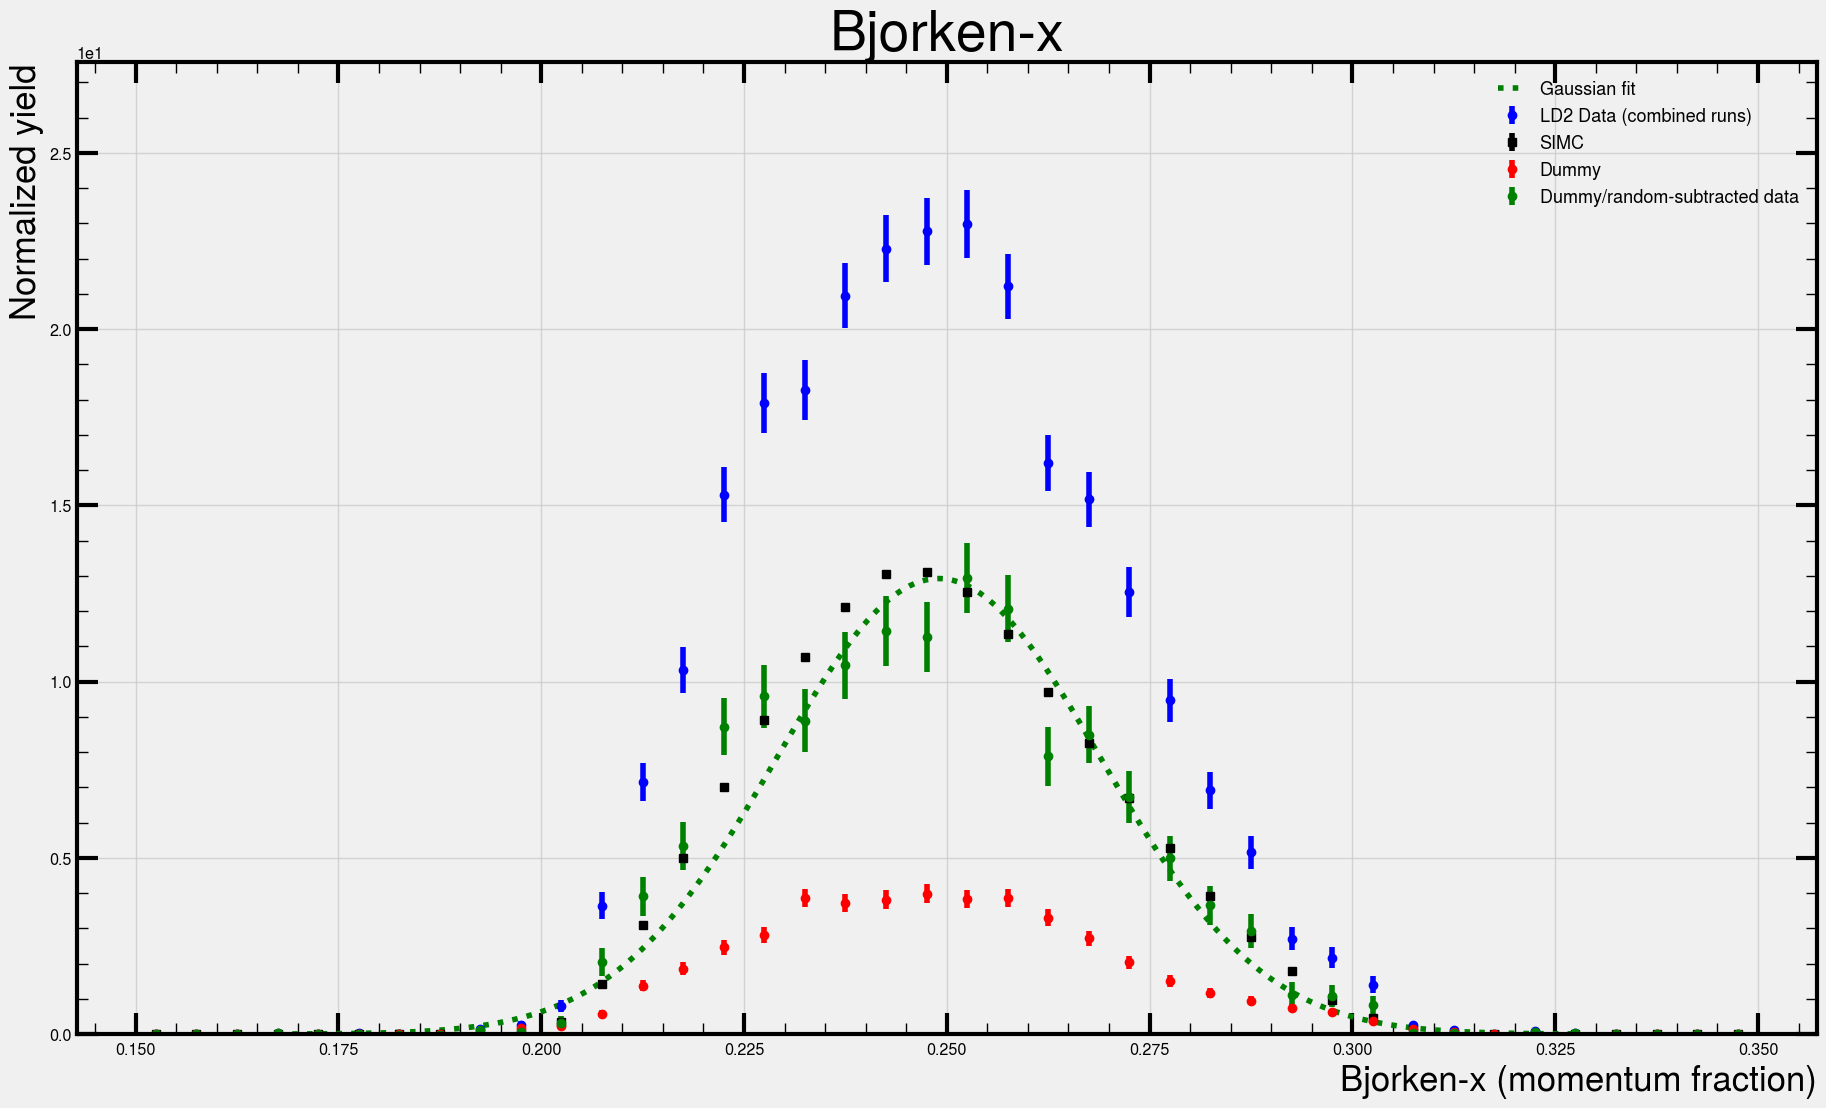

In [14]:
from scipy.optimize import curve_fit

bin_num = 40
var_to_plot = ["H.kin.primary.x_bj","xbj"]
bin_range = (0.15, 0.35)

histo = make_histograms(bin_num, bin_range)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

mask = histo["counts_sub"] > 0
x_fit = histo["centers_sub"][mask]
y_fit = histo["counts_sub"][mask]
y_err = histo["errors_sub"][mask]

p0 = [np.max(y_fit), np.mean(x_fit), np.std(x_fit)]

popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)

A_fit, mu_fit, sigma_fit = popt
A_err, mu_err, sigma_err = np.sqrt(np.diag(pcov))


diff_percent = 100 * (histo["counts_sub"][mask] - histo["counts_sim"][mask]) / histo["counts_sim"][mask]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")
print(f"μ = {mu_fit:.4f} ± {mu_err:.4f}")

plt.figure(figsize=(20, 12))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='LD2 Data (combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy/random-subtracted data")
x_smooth = np.linspace(np.min(x_fit), np.max(x_fit), 500)
plt.plot(x_smooth, gaussian(x_smooth, *popt), color='green', linestyle="dotted", label="Gaussian fit")
plt.xlabel("Bjorken-x (momentum fraction)", fontsize=25)
plt.ylabel("Normalized yield", fontsize=25)
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.minorticks_on()
ax=plt.gca()
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')
plt.tick_params(which='major', length=15, width=3, direction='in', bottom=True, top=True, left=True, right=True)
plt.tick_params(which='minor', length=8, width=1, direction='in', bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.titlesize"] = 40  
plt.title("Bjorken-x")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()

# Q^2

Average relative difference: 856.37%
μ = 3.2871 ± 0.0066


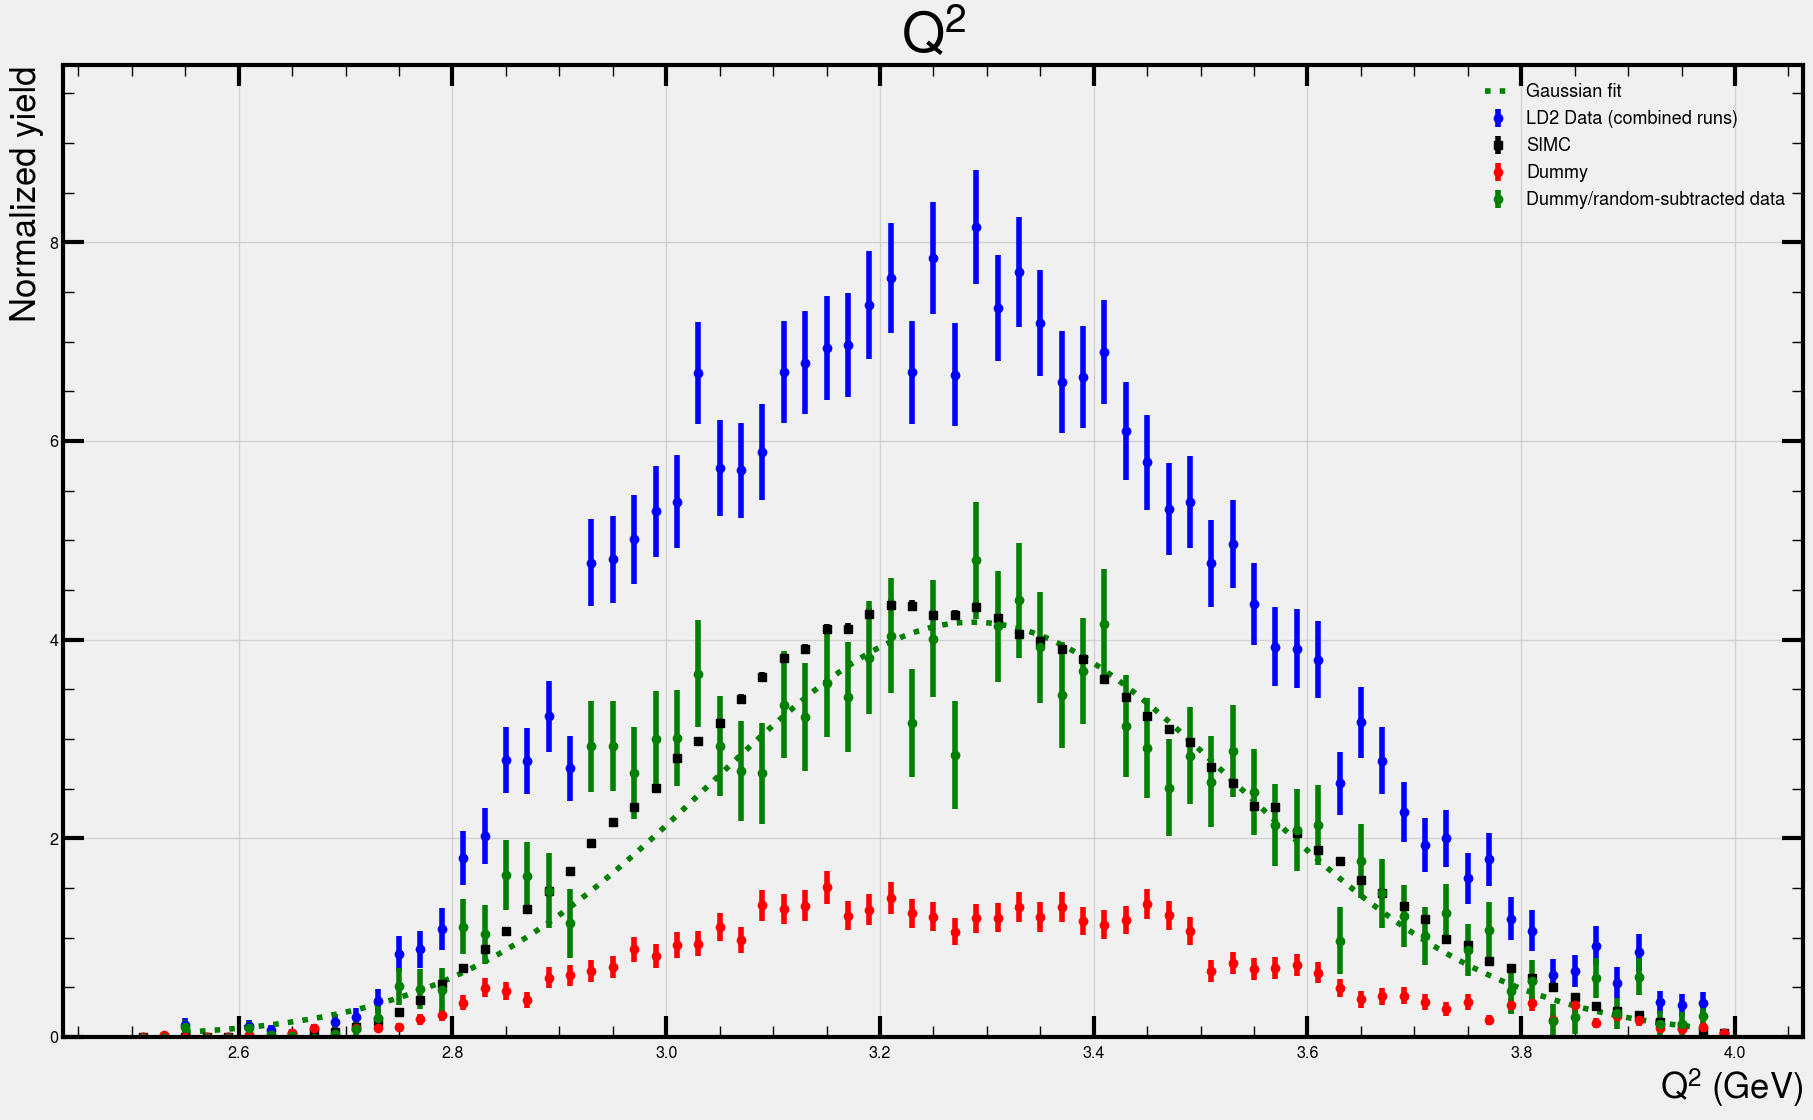

In [15]:
bin_num = 75
var_to_plot = ["H.kin.primary.Q2", "Q2"]
bin_range = (2.5, 4)

histo = make_histograms(bin_num, bin_range)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

mask = histo["counts_sub"] > 0
x_fit = histo["centers_sub"][mask]
y_fit = histo["counts_sub"][mask]
y_err = histo["errors_sub"][mask]

p0 = [np.max(y_fit), np.mean(x_fit), np.std(x_fit)]

popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0, sigma=y_err, absolute_sigma=True)

A_fit, mu_fit, sigma_fit = popt
A_err, mu_err, sigma_err = np.sqrt(np.diag(pcov))


mask = histo["counts_sim"]>0
diff_percent = 100 * (histo["counts_sub"][mask] - histo["counts_sim"][mask]) / histo["counts_sim"][mask]
mean_diff = np.mean(np.abs(diff_percent))
print(f"Average relative difference: {mean_diff:.2f}%")
print(f"μ = {mu_fit:.4f} ± {mu_err:.4f}")
plt.figure(figsize=(20, 12))

plt.errorbar(histo["centers_data"], histo["counts_data"], yerr=histo["errors_data"], fmt='o', color='blue', label='LD2 Data (combined runs)')
plt.errorbar(histo["centers_sim"], histo["counts_sim"], yerr=histo["errors_sim"], fmt='s', color='black', label='SIMC')
plt.errorbar(histo["centers_dummy"], histo["counts_dummy"], yerr=histo["errors_dummy"], fmt='o', color='red', label="Dummy")
plt.errorbar(histo["centers_sub"], histo["counts_sub"], yerr=histo["errors_sub"], fmt='o', color='green', label="Dummy/random-subtracted data")
x_smooth = np.linspace(np.min(x_fit), np.max(x_fit), 500)
plt.plot(x_smooth, gaussian(x_smooth, *popt), color='green', linestyle="dotted", label="Gaussian fit")
plt.xlabel(r"$Q^2$ (GeV)", fontsize=25)
plt.ylabel("Normalized yield", fontsize=25)
plt.ylim(0, max(histo["counts_data"])*1.2)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.minorticks_on()
ax=plt.gca()
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')
plt.tick_params(which='major', length=15, width=3, direction='in', bottom=True, top=True, left=True, right=True)
plt.tick_params(which='minor', length=8, width=1, direction='in', bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.titlesize"] = 40  
plt.title(r"$Q^2$")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()